 Table of contents
1. [Team members](#team)
2. [Libraries](#libraries)
3. [Exploring data](#exploring)
4. [Preprocessing data](#preprocessing)
5. [Questions](#questions)
    - [Question 1](#question-1)
    - [Question 2](#question-2)
    - [Question 3](#question-3)
    - [Question 4](#question-4)
    - [Question 5](#question-5)
6. [Modelling](#modelling)
    - [Data preparation](#modelling_preparation)
    - [Models: ](#models)
        - [Model 1 (change the number to the name of model. Ex: 1 -> Logistic Regression)](#model1)
    - [Evaluation](#evaluation)
7. [Reflection](#reflection)
    - [Difficulties during the project](#difficulties)
    - [Useful things learned](#useful)
    - [Plans to improve if have more time](#plans)
8. [References](#references)

<h1 id = "team">1. Team members</h1>
<style>
  table {
    margin: auto;
    width: 45%; /* Adjust the width as needed */
  }
  td {
    text-align: center;
    padding: 8px; /* Adding padding for better readability */
  }
  th
  {
    text-align: center;
  }
</style>

<table>
    <tr>
        <th> ID </th>
        <th> NAME </th>
    </tr>
    <tr>
        <td>22127148</td>
        <td>Dương Nhật Huy</td>
    </tr>
    <tr>
        <td>22127224</td>
        <td>Trương Thuận Kiệt</td>
    </tr>
    <tr>
        <td>22127257</td>
        <td>Phạm Minh Mẫn</td>
    </tr>
    <tr>
        <td>22127492</td>
        <td>Hồ Đăng Phúc</td>
    </tr>

<h1 id = "libraries"> 2. Libraries </h1>

In [180]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
from scipy.stats import sem


In [181]:
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.stats import ttest_ind

<h1 id = "exploring"> 3. Exploring data</h1>

In [182]:
raw_data  = pd.read_csv('./Data/full_data.csv')

In [183]:
raw_data.head()

,Title,CriticScore,UserScore,Link,PlatformReleased,Cast,Director,Genre,Rating,Runtime,Studio,Release Date,Production Budget,Domestic Gross,Worldwide Gross,Formated name,Metascore,Userscore
0,L.A. Confidential,99%,94%,https://www.rottentomatoes.com/m/la_confidential,Cinema,"Kevin Spacey, Russell Crowe, Guy Pearce, James...",Curtis Hanson,"Crime, Drama",R,2h 16m,Warner Home Vídeo,"Sep 19, 1997","$35,000,000","$64,604,977","$126,204,977",l.a.confidential,91,8.6
1,The Godfather,97%,98%,https://www.rottentomatoes.com/m/the_godfather,Cinema,"Marlon Brando, Al Pacino, James Caan, Richard ...",Francis Ford Coppola,"Crime, Drama",R,2h 57m,Paramount Pictures,"Mar 15, 1972","$7,000,000","$136,479,994","$270,007,394",thegodfather,100,9.3
2,Casablanca,99%,95%,https://www.rottentomatoes.com/m/1003707-casab...,Cinema,"Humphrey Bogart, Ingrid Bergman, Paul Henreid,...",Michael Curtiz,Drama,PG,1h 42m,Warner Bros. Pictures,"Jan 23, 1943","$1,039,000","$10,462,500","$10,567,179",casablanca,100,8.7
3,Parasite,99%,90%,https://www.rottentomatoes.com/m/parasite_2019,Cinema,"Song Kang-ho, Lee Sun-kyun, Jo Yeo-jeong, Choi...",Bong Joon Ho,"Comedy, Mystery & Thriller, Drama",R,2h 12m,Neon,"May 30, 2019","$11,800,000","$53,369,745","$253,267,858",parasite,97,8.9
4,Top Gun: Maverick,96%,99%,https://www.rottentomatoes.com/m/top_gun_maverick,Cinema,"Tom Cruise, Miles Teller, Jennifer Connelly, J...",Joseph Kosinski,"Action, Adventure",PG-13,2h 11m,Paramount Pictures,"May 20, 2022","$170,000,000","$718,732,821","$1,464,400,233",topgun:maverick,78,8.4


### Number of rows and columns

In [184]:
shape = raw_data.shape  
shape

(5106, 18)

### The meaning of each line

- Each line of the dataset is a record of a movie, and all records include various features of the movie like Name, Genres, Cast, Budget, Revenue, Runtime, etc

### Duplicated rows

In [185]:
num_duplicates = raw_data.duplicated().sum()
num_duplicates

np.int64(0)

Phew, luckily no duplicated rows

### The meaning of each column
- Title: The film title.
- CriticScore and UserScore: Percentage-based scores from critics and users, respectively.
- Link: URLs to movie pages.
- PlatformReleased: Indicates release platforms, such as Cinema.
- Cast and Director: Names of the main cast members and director.
- Genre, Rating, and Runtime: Film genre, content rating (e.g., PG, R), and runtime.
- Studio: The studio responsible for production or distribution.
- Release Date: Specific release date.
- Production Budget, Domestic Gross, and Worldwide Gross: Financial details in terms of budget and revenue.
- Metascore and Usescore: Average scores given by critics and users on Metacritic website.

### Data type of each column

In [186]:
dtype = raw_data.dtypes
dtype

Title                object
CriticScore          object
UserScore            object
Link                 object
PlatformReleased     object
Cast                 object
Director             object
Genre                object
Rating               object
Runtime              object
Studio               object
Release Date         object
Production Budget    object
Domestic Gross       object
Worldwide Gross      object
Formated name        object
Metascore            object
Userscore            object
dtype: object

As can be seen that, all types of each colum are currently objects. Therefore, those needs re-typing

### Data retyping

+ Title, Link, PlatformReleased, Studio : These are meant to be string, so there no need to convert it

+ CriticScore and UserScore are numbers, therfore we convert them into numerical datatype

Note : All numerical value are kept in float not interger because numpy require float to store nan

In [187]:
#Remove '%' notation and keep the score
def get_score_percentage(score_str):
    if pd.isna(score_str) or score_str == 'nan' or score_str == 'NaN':
        return np.nan
    elif re.match(r'^\d{1,3}%$', score_str):
            return float(score_str[:-1])
    return np.nan

raw_data['CriticScore'] = raw_data['CriticScore'].apply(get_score_percentage)
raw_data['UserScore'] = raw_data['UserScore'].apply(get_score_percentage)

+ Convert MetaScore and UserScore into Numerical datatype too

In [188]:
#Check if a string is a valid number because there are invalid value in Metascore and Userscore
def get_score(score_str):
    if pd.isna(score_str) or score_str == 'nan' or score_str == 'NaN':
        return np.nan
    elif re.match(r'^-?\d+(\.\d+)?$', score_str):
        return float(score_str)
    return np.nan
    
raw_data['Metascore'] = raw_data['Metascore'].apply(get_score)
raw_data['Userscore'] = raw_data['Userscore'].apply(get_score)


+ Because a movie may have many Actors, many Director and different Gern, we split them and store into a list

In [189]:
#Split string by comma seperated
def split_item(string):
    if pd.isna(string) or string == 'nan' or string == 'NaN':
        return pd.NA
    else:
        return string.split(', ')
    
raw_data['Cast'] = raw_data['Cast'].apply(split_item)
raw_data['Genre'] = raw_data['Genre'].apply(split_item)
raw_data['Director'] = raw_data['Director'].apply(split_item)

+ There are 10 different ratings, so we convert them into Pandas Categorial

In [190]:
raw_data['Rating'] = raw_data['Rating'].astype('category')

+ We convert Runtime into dictionary consists of hours and minutes for easier operating

In [191]:


# Collect runtime information and convert it into dictionary
def get_runtime(runtime_str):
    if pd.isna(runtime_str) or runtime_str == 'nan' or runtime_str == 'NaN':
        return pd.NA
    else:
        runtime = runtime_str.split()

        if 'h' in runtime[0]:   
            hours = int(runtime[0].split('h')[0])
            minutes = int(runtime[1].split('m')[0])
        else:
            hours = 0
            minutes = int(runtime[0].split('m')[0])
        return {'hours' : hours, 'minutes': minutes}

raw_data['Runtime'] = raw_data['Runtime'].apply(get_runtime)


+ We convert release date into Pandas Datetime

In [192]:
month_dict = {'Jan' : 1, 'Feb' : 2, 'Mar' : 3, 'Apr' : 4, 'May' : 5, 'Jun' : 6, 'Jul' : 7, 'Aug' : 8, 'Sep' : 9, 'Oct' : 10, 'Nov' : 11, 'Dec' : 12}

# Collect date string and store it into datetime format
def parse_datetime(date_str):
    if pd.isna(date_str) or date_str == 'nan' or date_str == 'NaN' or date_str == 'Unknown':
        return pd.NaT
    else:
        date = date_str.replace(',','').split()
        if len(date) == 1:
            year = int(date[0])
            return pd.to_datetime(year, format ='%Y')
        elif len(date) == 2:
            month = month_dict[date[0]]
            year = int(date[1])
            day = 1
            return pd.to_datetime(f'{year}-{month}-{day}', format='%Y-%m-%d')
        else:
            month = month_dict[date[0]]
            day = int(date[1])
            year = int(date[2])
            return pd.to_datetime(f'{year}-{month}-{day}', format='%Y-%m-%d')

raw_data['Release Date'] = raw_data['Release Date'].apply(parse_datetime)
    

+ Finally, convert Budgets and Grossess into numerical datatype and we are done

In [193]:
# Replace $ notation, replace comma and get the value
def parse_money(money_str):
    if pd.isna(money_str) or money_str == 'nan' or money_str == 'NaN':
        return np.nan
    else:
        money_str = money_str.replace('$','').replace(',','')
        return float(money_str)

raw_data['Production Budget'] = raw_data['Production Budget'].apply(parse_money)         
raw_data['Domestic Gross'] = raw_data['Domestic Gross'].apply(parse_money)
raw_data['Worldwide Gross'] = raw_data['Worldwide Gross'].apply(parse_money)

+ Rename UserScore, Userscrore columns and drop Formated name columns because we dont use it

In [194]:
raw_data.rename(columns={'UserScore' : 'Tomatoes UserScore', 'Userscore' : 'Meta UserScore', 'CriticScore' : 'Tomatoes CriticScore', 'MetaScore': 'Meta CriticScore'}, inplace=True)

raw_data = raw_data.drop('Formated name', axis=1)

In [195]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5106 entries, 0 to 5105
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Title                 5106 non-null   object        
 1   Tomatoes CriticScore  4129 non-null   float64       
 2   Tomatoes UserScore    4523 non-null   float64       
 3   Link                  5106 non-null   object        
 4   PlatformReleased      5106 non-null   object        
 5   Cast                  5074 non-null   object        
 6   Director              5071 non-null   object        
 7   Genre                 5060 non-null   object        
 8   Rating                4015 non-null   category      
 9   Runtime               5036 non-null   object        
 10  Studio                5059 non-null   object        
 11  Release Date          5031 non-null   datetime64[ns]
 12  Production Budget     5106 non-null   float64       
 13  Domestic Gross    

In [196]:
raw_data.head()

,Title,Tomatoes CriticScore,Tomatoes UserScore,Link,PlatformReleased,Cast,Director,Genre,Rating,Runtime,Studio,Release Date,Production Budget,Domestic Gross,Worldwide Gross,Metascore,Meta UserScore
0,L.A. Confidential,99.0,94.0,https://www.rottentomatoes.com/m/la_confidential,Cinema,"[Kevin Spacey, Russell Crowe, Guy Pearce, Jame...",[Curtis Hanson],"[Crime, Drama]",R,"{'hours': 2, 'minutes': 16}",Warner Home Vídeo,1997-09-19,35000000.0,64604977.0,1.262050e+08,91.0,8.6
1,The Godfather,97.0,98.0,https://www.rottentomatoes.com/m/the_godfather,Cinema,"[Marlon Brando, Al Pacino, James Caan, Richard...",[Francis Ford Coppola],"[Crime, Drama]",R,"{'hours': 2, 'minutes': 57}",Paramount Pictures,1972-03-15,7000000.0,136479994.0,2.700074e+08,100.0,9.3
2,Casablanca,99.0,95.0,https://www.rottentomatoes.com/m/1003707-casab...,Cinema,"[Humphrey Bogart, Ingrid Bergman, Paul Henreid...",[Michael Curtiz],[Drama],PG,"{'hours': 1, 'minutes': 42}",Warner Bros. Pictures,1943-01-23,1039000.0,10462500.0,1.056718e+07,100.0,8.7
3,Parasite,99.0,90.0,https://www.rottentomatoes.com/m/parasite_2019,Cinema,"[Song Kang-ho, Lee Sun-kyun, Jo Yeo-jeong, Cho...",[Bong Joon Ho],"[Comedy, Mystery & Thriller, Drama]",R,"{'hours': 2, 'minutes': 12}",Neon,2019-05-30,11800000.0,53369745.0,2.532679e+08,97.0,8.9
4,Top Gun: Maverick,96.0,99.0,https://www.rottentomatoes.com/m/top_gun_maverick,Cinema,"[Tom Cruise, Miles Teller, Jennifer Connelly, ...",[Joseph Kosinski],"[Action, Adventure]",PG-13,"{'hours': 2, 'minutes': 11}",Paramount Pictures,2022-05-20,170000000.0,718732821.0,1.464400e+09,78.0,8.4


### Numerical column exploration

For columns with numeric data types, calculate:
- Percentage of missing values (From this and further calculation to propose a suitable approach to fill missing values of that column)
- The min
- The lower quartile
- The median
- The upper quartile
- The max
After calculating, give **visualization** to help get deeper understanding of data, from that graph/chart give some comments on the values' distribution of that column

In [197]:
numerical_cols = raw_data.select_dtypes(include=['number']).columns
numerical_cols

Index(['Tomatoes CriticScore', 'Tomatoes UserScore', 'Production Budget',
       'Domestic Gross', 'Worldwide Gross', 'Metascore', 'Meta UserScore'],
      dtype='object')

In [198]:
type(raw_data['Metascore'])

pandas.core.series.Series

### Support Function

In [199]:
def descriptive_stats(col : pd.core.series.Series):
    ''' 
    Function to calculate descriptive statistics for a given column
    Input:
        col : pd.core.series.Series : A pandas series object
    Output:
        dict : A dictionary containing the descriptive statistics
    
    '''

    mean = col.mean()
    median = col.median()
    mode = col.mode().values[0] if len(col.mode()) > 0 else None
    quartiles = col.quantile([0.25, 0.5, 0.75]).values
    percentiles = col.quantile([0.1, 0.9]).values
    deciles = col.quantile([i/10 for i in range(1, 10)]).values
    min_val = col.min()
    max_val = col.max()

    return {'mean': mean, 'median': median, 'mode': mode, 'quartiles': quartiles, 'percentiles': percentiles, 'deciles': deciles, 'min': min_val, 'max': max_val}


def histogram_plot(data = [], title = '', xlabel = '', ylabel = '', color = '', mean_line = False, median_line = False, bins = range(0, 100, 20)):
    ''' 
    Function to plot a histogram of a given dataset
    Input:
        data : list : A list of numerical values
        title : str : Title of the plot
        xlabel : str : Label for the x-axis
        ylabel : str : Label for the y-axis
        color : str : Color of the histogram
        mean_line : bool : Whether to plot a line for the mean
        median_line : bool : Whether to plot a line for the median
        bins : list : List of bin edges for the histogram
    '''


    plt.figure(figsize=(8,8))
    sns.histplot(data, bins=bins, color=color)
    plt.xticks(bins)

    if mean_line:
        mean_val = data.mean()
        plt.axvline(mean_val, color='blue', linestyle='-', linewidth=1.5, label=f"Mean: {mean_val:.1f}")
    if median_line:
        median_val = data.median()
        plt.axvline(median_val, color='red', linestyle='-', linewidth=1.5, label=f"Median: {median_val:.1f}")

    plt.title(title, fontweight='bold')
    plt.xlabel(xlabel, fontweight='bold')
    plt.ylabel(ylabel, fontweight = 'bold')
    plt.legend()
    plt.show()



mlb = MultiLabelBinarizer()
raw_data_tmp = raw_data.copy()
raw_data_tmp['Genre'] = raw_data_tmp['Genre'].fillna("")
genre_onehot = pd.DataFrame(mlb.fit_transform(raw_data_tmp['Genre']), columns=mlb.classes_, index=raw_data_tmp.index)

rating_onehot = pd.get_dummies(raw_data_tmp['Rating'], prefix='Rating').astype(int)

raw_data_tmp = pd.concat([raw_data_tmp, genre_onehot, rating_onehot], axis=1)
raw_data_tmp = raw_data_tmp.drop(['Genre', 'Rating'], axis=1)

# Conduct t-test between missing and non missing groups for target column
def missing_ttest(target_col, data = raw_data_tmp):
    ''' 
    Function to conduct t-test between missing and non-missing groups for each numerical column
    Input:
        target_col : str : The target column to check for missing values
        data : pd.DataFrame : The dataframe containing the data
    Output:
        p_values_sorted : pd.DataFrame : A dataframe containing the p-values sorted in ascending order
        proportion_significant : float : The proportion of significant features
    '''

    p_values = {}

    for col in data.columns:
        if col != target_col and np.issubdtype(data[col].dtype, np.number):
            missing_group = data[data[target_col].isna()][col]
            non_missing_group = data[~data[target_col].isna()][col]

            if len(missing_group) > 0 and len(non_missing_group) > 0:
                ttest_result = ttest_ind(missing_group, non_missing_group, nan_policy='omit')
                p_values[col] = ttest_result.pvalue

    # Convert p-values to dataframe and sort by p-value for easy viewing
    p_values_df = pd.DataFrame(list(p_values.items()), columns=['Column', 'pvalue'])
    p_values_sorted = p_values_df.sort_values(by='pvalue', ascending=False)

    # Calculate proportion of significant features
    significant_features = p_values_sorted[p_values_sorted['pvalue'] < 0.05]
    proportion_significant = significant_features.shape[0] / p_values_sorted.shape[0]

    return p_values_sorted, proportion_significant


# Tomatoes CriticsScore

- Missing Ratio

In [200]:
print("Percentage of missing values: ", raw_data['Tomatoes CriticScore'].isna().mean()*100)

Percentage of missing values:  19.134351743047397


- Correlation among other numerical features

In [201]:
# conduct t-test between missing and non-missing groups for 'Tomatoes CriticScore'
p_values_sorted, proportion_significant = missing_ttest(target_col='Tomatoes CriticScore')

# Display results
print("T-test p-values between missing and non-missing groups for 'Tomatoes CriticScore':")
print(p_values_sorted)

print(f"Proportion of significant features: {proportion_significant:.2f}")

T-test p-values between missing and non-missing groups for 'Tomatoes CriticScore':
                  Column        pvalue
8              Animation  7.757713e-01
9                  Anime  6.331468e-01
29                Sports  6.267054e-01
15  Faith & Spirituality  6.267054e-01
17               Foreign  6.267054e-01
19               Holiday  2.981110e-01
20                Horror  2.793797e-01
39          Rating_TV-MA  2.785175e-01
24               Musical  2.132383e-01
33          Rating_NC-17  1.978649e-01
14                 Drama  1.974160e-01
25    Mystery & Thriller  1.968717e-01
12                 Crime  6.487590e-02
26                 Other  3.979249e-02
30                   War  3.676100e-02
32              Rating_G  2.419578e-02
31               Western  1.580981e-02
38           Rating_TV-G  1.051493e-02
23                 Music  9.429270e-03
22                LGBTQ+  5.428654e-03
27               Romance  3.474896e-03
4              Metascore  2.863810e-03
18               His

Most of p-values are < 0.05, suggesting that there is no significant difference between the groups with and without Tomatoes CriticScore and rate of p-values is 0.66, which is quite high<br>
It is likely that the missingness of Tomatoes CriticScore is **MAR** 

- Distribution of values

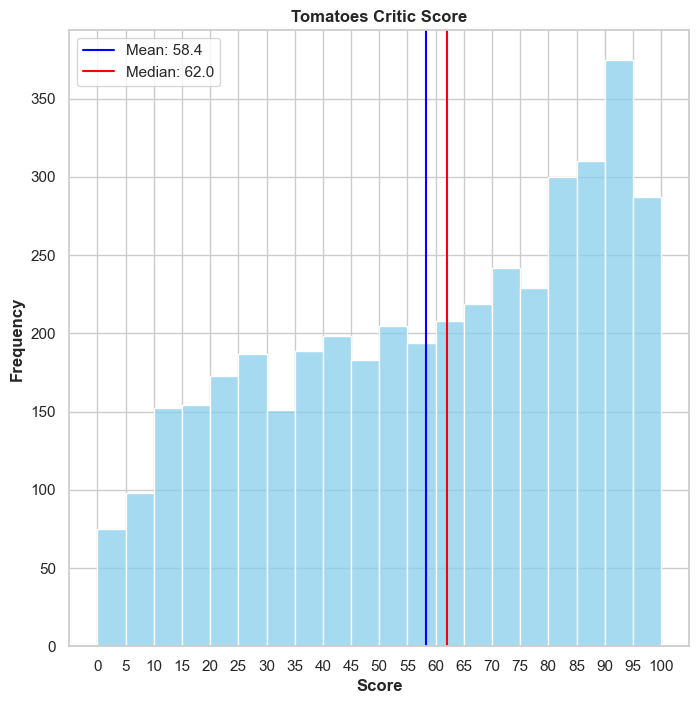

In [202]:
min_score = raw_data['Tomatoes CriticScore'].min()
max_score = raw_data['Tomatoes CriticScore'].max()

# Plot histogram of 'Tomatoes CriticScore'
histogram_plot(data = raw_data['Tomatoes CriticScore'], title = 'Tomatoes Critic Score', xlabel = 'Score', ylabel = 'Frequency', color = 'skyblue', mean_line = True, median_line = True, bins = range(int(min_score), int(max_score)+1, 5))

- Descriptive Statistics

In [203]:
#Descriptive statistics of the 'Tomatoes CriticScore'
stats = descriptive_stats(raw_data['Tomatoes CriticScore'])

#Range
data_range = [stats['min'], stats['max']]

print("Mean: ", stats['mean'])
print("Median: ", stats['median'])
print("Mode: ", stats['mode'])
print("Quartiles: ", stats['quartiles'])
print("Percentiles: ", stats['percentiles'])
print("Deciles: ", stats['deciles'])
print("Range: ", data_range)


Mean:  58.367885686606925
Median:  62.0
Mode:  93.0
Quartiles:  [35. 62. 83.]
Percentiles:  [17. 93.]
Deciles:  [17. 29. 41. 51. 62. 71. 80. 87. 93.]
Range:  [np.float64(0.0), np.float64(100.0)]


**Mean (58.37):** On average, movies tend to receive a critic score around 58.37 out of 100.

**Median (62):** The median being higher than the mean suggests a positive skew in the distribution, meaning there are more movies with lower scores compared to higher scores.

**Mode (93):** The most frequent critic score is 93. This could be due to a few movies that received exceptionally high ratings.

**Quartiles:**

-   Q1 (35): 25% of the movies have a critic score of 35 or lower.
-   Q2 (Median, 62): 50% of the movies have a critic score of 62 or lower.
-   Q3 (83): 75% of the movies have a critic score of 83 or lower.
    
**Percentiles:**

- P10 (17): 10% of the movies have a critic score of 17 or lower.
- P90 (93): 90% of the movies have a critic score of 93 or lower.

**Deciles:** Movies tend to receive quite equal user scores from rotten tomatoes.

**Range (0-100):** This indicates that the critic scores range from 0 to 100, which is expected for a rating system.

**Overall, the summary statistics suggest a distribution that is skewed towards lower scores, with a few outliers on the higher end.**

# Tomatoes UserScore

- Missing Ratio

In [204]:
print("Percentage of missing values: ", raw_data['Tomatoes UserScore'].isna().mean()*100)

Percentage of missing values:  11.417939678809244


- Correlation among other numerical features

In [205]:
# conduct t-test between missing and non-missing groups for 'Tomatoes UserScore'
p_values_sorted, proportion_significant = missing_ttest(target_col='Tomatoes UserScore')

# Display results
print("T-test p-values between missing and non-missing groups for 'Tomatoes UserScore':")
print(p_values_sorted)

print(f"Proportion of significant features: {proportion_significant:.2f}")


T-test p-values between missing and non-missing groups for 'Tomatoes UserScore':
                  Column        pvalue
39          Rating_TV-MA  9.768950e-01
38           Rating_TV-G  8.113520e-01
24               Musical  7.887967e-01
15  Faith & Spirituality  7.196164e-01
29                Sports  7.196164e-01
37          Rating_TV-14  6.145822e-01
8              Animation  4.942390e-01
33          Rating_NC-17  3.419376e-01
19               Holiday  3.306256e-01
4              Metascore  3.132494e-01
9                  Anime  3.095978e-01
12                 Crime  1.945396e-01
31               Western  6.005794e-02
32              Rating_G  4.403612e-02
30                   War  4.154914e-02
27               Romance  2.883157e-02
23                 Music  2.632155e-02
0   Tomatoes CriticScore  1.996478e-02
5         Meta UserScore  1.207926e-02
25    Mystery & Thriller  1.143898e-02
22                LGBTQ+  9.267475e-03
26                 Other  5.336372e-03
17               Forei

Most of p-values are < 0.05, suggesting that there is no significant difference between the groups with and without Tomatoes CriticScore and rate of p-values is 0.72, which is quite high<br>
It is likely that the missingness of Tomatoes UserScore is **MAR** 

- Distribution of values

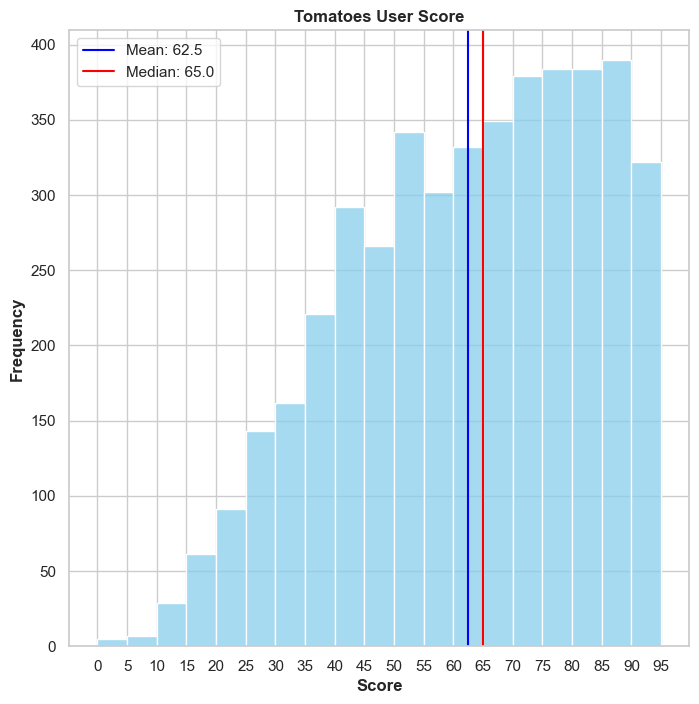

In [206]:
# Bar chart of scores
histogram_plot(data = raw_data['Tomatoes UserScore'], title = 'Tomatoes User Score', xlabel = 'Score', ylabel = 'Frequency', color = 'skyblue', mean_line = True, median_line = True, bins = range(0, 100, 5))

- Descriptive Statistics

In [207]:
#Descriptive statistics of the 'Tomatoes UserScore'
stats = descriptive_stats(raw_data['Tomatoes UserScore'])

#Range
data_range = [stats['min'], stats['max']]

print("Mean: ", stats['mean'])
print("Median: ", stats['median'])
print("Mode: ", stats['mode'])
print("Quartiles: ", stats['quartiles'])
print("Percentiles: ", stats['percentiles'])
print("Deciles: ", stats['deciles'])
print("Range: ", data_range)


Mean:  62.45743975237674
Median:  65.0
Mode:  79.0
Quartiles:  [47. 65. 80.]
Percentiles:  [33. 89.]
Deciles:  [33. 43. 51. 58. 65. 71. 77. 83. 89.]
Range:  [np.float64(0.0), np.float64(100.0)]


**Mean (62.45):** On average, movies tend to receive a user score around 62.45 out of 100.

**Median (65):** The median being higher than the mean suggests a positive skew in the distribution, meaning there are more movies with lower scores compared to higher scores.

**&rarr; The mean (62.46) and median (65.0) values are relatively high, especially when considering a scoring scale that ranges from 0 to 100. This suggests that, on average, users are rating items above the midpoint (50), indicating a general tendency to rate positively**

**Mode (79):** The most frequent critic score is 79. This could be due to a few movies that received exceptionally high ratings.

**&rarr; A significant number of users have rated items favorably, as scores in the upper range are generally seen as positive**

**Quartiles:**

-   Q1 (47): 25% of the movies have a critic score of 47 or lower.
-   Q2 (Median, 65): 50% of the movies have a critic score of 65 or lower.
-   Q3 (80): 75% of the movies have a critic score of 89 or lower.
    
**&rarr; Many users are giving high ratings**
 
**Percentiles:**

- P10 (33): 10% of the movies have a critic score of 33 or lower.
- P90 (89): 90% of the movies have a critic score of 89 or lower.

**Deciles:** Movies tend to receive quite equal user score from rotten tomatoes.

**Range (0-100):** This indicates that the critic scores range from 0 to 100, which is expected for a rating system.

**While the presence of low scores does indicate that not all ratings are high, the overall trend in the statistics shows a clustering of scores towards the upper end. This is a common pattern seen in products or content that are generally well-received.**

# Production Budget

- Missing Ratio

In [208]:
print("Percentage of missing values: ", raw_data['Production Budget'].isna().mean()*100)

Percentage of missing values:  0.0


Luckily, no missing values

- Distribution of values

<Axes: title={'center': 'Production Budget Over Time'}, xlabel='Release Date'>

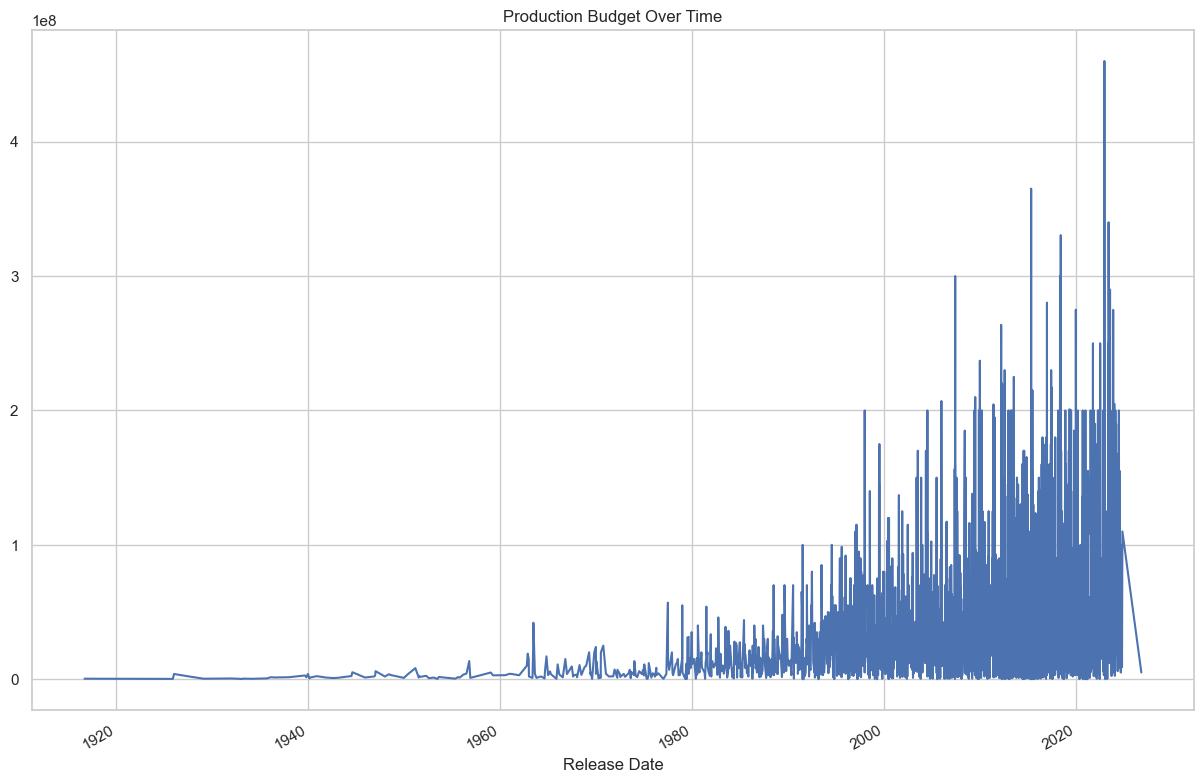

In [209]:
# Line graph of production budget over time
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
raw_data.groupby('Release Date')['Production Budget'].mean().plot(title='Production Budget Over Time', ax=ax)


- Descriptive Statistics

In [210]:
#Descriptive statistics of the 'Production Budget'
stats = descriptive_stats(raw_data['Production Budget'])

#Range
data_range = [stats['min'], stats['max']]

print("Mean: ", stats['mean'])
print("Median: ", stats['median'])
print("Mode: ", stats['mode'])
print("Quartiles: ", stats['quartiles'])
print("Percentiles: ", stats['percentiles'])
print("Deciles: ", stats['deciles'])
print("Range: ", data_range)




Mean:  33937859.52781042
Median:  18000000.0
Mode:  20000000.0
Quartiles:  [ 5000000. 18000000. 43750000.]
Percentiles:  [ 1200000. 85000000.]
Deciles:  [ 1200000.  3750000.  7000000. 12000000. 18000000. 25000000. 35000000.
 52000000. 85000000.]
Range:  [np.float64(86.0), np.float64(460000000.0)]


**Mean (33,937,859.53):** The average production budget is approximately 33,937,859.53. This indicates that, on average, films are funded at a substantial level, suggesting a significant investment in movie production.

**Median (18,000,000.0):** The median budget being 18,000,000.0 is notably lower than the mean, indicating a positive skew in the distribution. This suggests that while there are some films with very high budgets, many productions operate with more modest funding levels.

**→ The mean (33,937,859.53) and median (18,000,000.0) values suggest that while there are high-budget films, a significant number of productions are budgeted below the average, highlighting a diverse range of film financing.**

**Mode (20,000,000.0):** The mode of 20,000,000.0 indicates that this is the most common budget level among films. This clustering suggests a popular threshold for many productions, potentially reflecting industry standards or target funding levels.

**&rarr; A considerable number of films are being funded around this budget mark, indicating a trend in production financing.**

**Quartiles:**

- Q1 (5,000,000): 25% of films have budgets of 5,000,000 or lower, illustrating that a notable portion of productions are budget-conscious.
- Q2 (Median, 18,000,000): 50% of productions have budgets of 18,000,000 or lower, reinforcing that half of the films operate with relatively lower funding.
- Q3 (43,750,000): 75% of films have budgets below 43,750,000, suggesting that a significant number of productions are still well below the high-budget threshold.

**&rarr;** The quartile data indicates a wide range of budgets across the industry, with a substantial number of films receiving moderate to high levels of funding.

**Percentiles:**

P10 (1,200,000): 10% of films have budgets of 1,200,000 or lower, indicating that there are some very low-budget projects in the market.
P90 (85,000,000): 90% of films are budgeted below 85,000,000, showcasing that while high-budget films exist, the majority still fall within a lower range.

**Deciles:** The decile analysis indicates a fairly even distribution of budgets, suggesting that production funding is relatively accessible across a spectrum of films.

**Range (0-460,000,000):** The range of budgets from 86.0 to 460,000,000.0 confirms the presence of extreme outliers, reflecting the diversity in production financing strategies.

**Overall, while the presence of low budgets indicates that not all productions are highly funded, the majority of the data reflects a tendency towards higher investment in film production. This suggests a competitive landscape where a mix of both high-budget and lower-budget films coexist, potentially allowing for varied audience engagement and market opportunities.**

# Domestic Gross

- Missing Ratio

In [211]:
print("Percentage of missing values: ", raw_data['Domestic Gross'].isna().mean()*100)

Percentage of missing values:  0.0


Luckily, no missing values

- Distribution of values

<Axes: title={'center': 'Domestic Gross Over Time'}, xlabel='Release Date'>

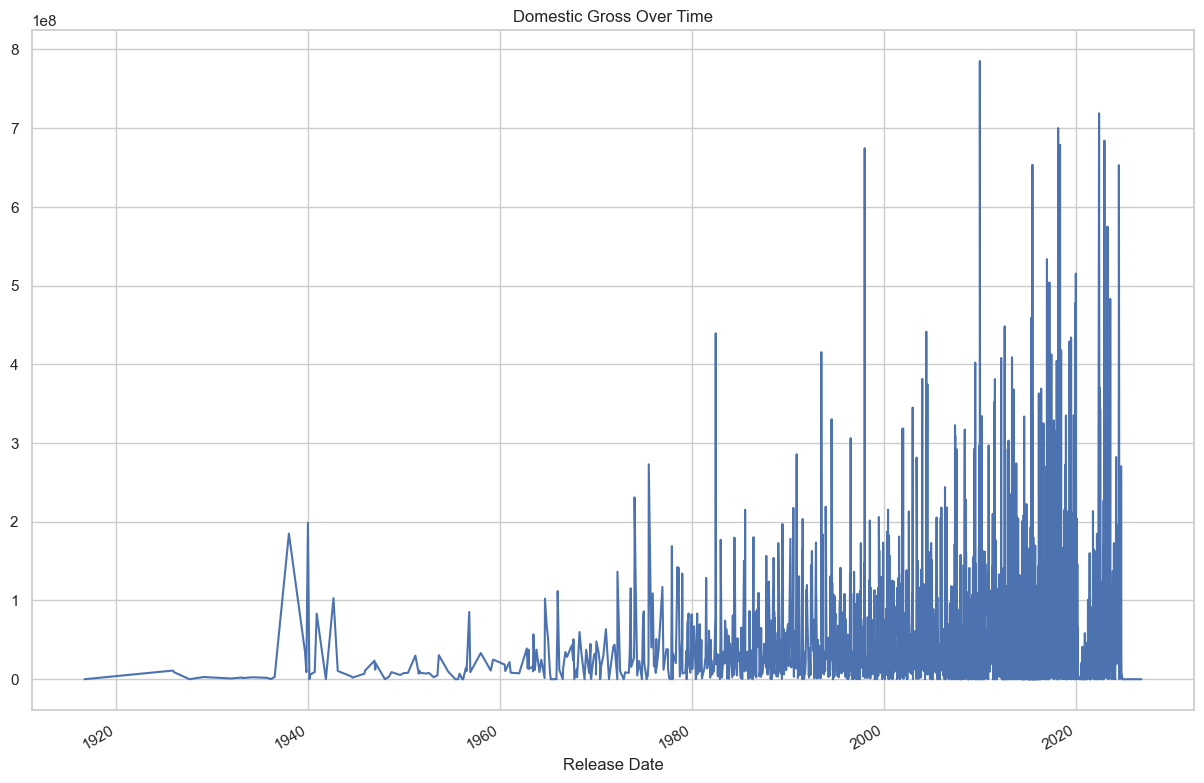

In [212]:
# Line graph of production budget over time
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
raw_data.groupby('Release Date')['Domestic Gross'].mean().plot(title='Domestic Gross Over Time', ax=ax)


Luckily, no missing values

- Descriptive Statistics

In [213]:
#Descriptive statistics of the 'Domestic Gross'
stats = descriptive_stats(raw_data['Domestic Gross'])

#Range
data_range = [stats['min'], stats['max']]

print("Mean: ", stats['mean'])
print("Median: ", stats['median'])
print("Mode: ", stats['mode'])
print("Quartiles: ", stats['quartiles'])
print("Percentiles: ", stats['percentiles'])
print("Deciles: ", stats['deciles'])
print("Range: ", data_range)



Mean:  43825054.271053664
Median:  17672451.0
Mode:  0.0
Quartiles:  [ 1431370.5 17672451.  54141177.5]
Percentiles:  [0.00000000e+00 1.16729653e+08]
Deciles:  [0.00000000e+00 4.09862000e+05 3.49233450e+06 9.63939000e+06
 1.76724510e+07 2.95000000e+07 4.45632045e+07 6.61840510e+07
 1.16729653e+08]
Range:  [np.float64(0.0), np.float64(858373000.0)]


**Mean (43,825,054.27):** The average domestic gross is approximately 43,825,054.27. This indicates that, on average, a reasonable return of films on domestic earnings across the production budget.

**Median (17,672,451.0):** The median budget being 17,672,451.0 is notably lower than the mean, indicating a positive skew in the distribution. This suggests that where a small number of films exceptionally high.

**→ Mean (43,825,054.27) and median (17,672,451.0) values suggest that while a few movies perform vary well domestically, the typical domestic gross is at very modest level**

**Mode (0.0):** The mode of 0.0 indicates that a number of films do not generate any domestic revenue, possibly due to limited or no domestic release.

**&rarr; This indicates that while many films have strong domestic performance, a portion either fails to secure domestic earnings or is released only internationally.**

**Quartiles:**

- Q1 (1,431,370.5): 25% of films have domestic return of 1,431,370.5 or lower, illustrating that a quarter of productions achieve limited domestic earnings.
- Q2 (Median, 17,672,451.0): 50% of domestic gross of 17,672,451.0 or lower, reinforcing the trend of moderate earnings for the majority.
- Q3 (54,141,177.5): 75% of films have budgets below 54,141,177.5, suggesting that only minority of film achieves high domestic success.

**&rarr;** The quartile data reflects a broad range of domestic gross figures, with most films falling below the highest-grossing tier.

**Percentiles:**

P10 (0.0): 10% of films can not generate domestic gross, reinforcing the mode value.
P90 (116,729,653): 90% of films gross are lower than 85,000,000, very high earnings are rare and achieved by a select few films.

**Deciles:** The decile analysis indicates a fairly consistent distribution of domestic gross, across the lower earnings tiers, with a significant increase only in the top deciles, highlighting the influence of high-grossing outliers.

**Range (0.0-858,373,000.0):** Underscores the variability in domestic gross potential, with a few films grossing exceptionally high amounts while others generate none.

**Overall, the descriptive statistics and the graph show a film industry where a small number of movies achieve high domestic grosses, while most perform modestly at the box office. The increase in domestic grosses over time reflects the industry's growing focus on blockbuster movies and larger theatrical releases, which tend to generate higher revenue. However, the strong skewness suggests that blockbuster successes are exceptions rather than the norm, highlighting the industry's reliance on a few high-grossing films to drive overall box office performance.**

# Worldwide Gross

+ Missing ratio

In [214]:
# Percentage of missing values in 'Worldwide Gross'
missing = raw_data['Worldwide Gross'].isnull().sum() / len(raw_data['Worldwide Gross']) * 100
print("Percentage of missing value: ", missing, '%')

Percentage of missing value:  0.0 %


+ Value Distribution

<Axes: title={'center': 'Worldwide Gross Over Time'}, xlabel='Release Date'>

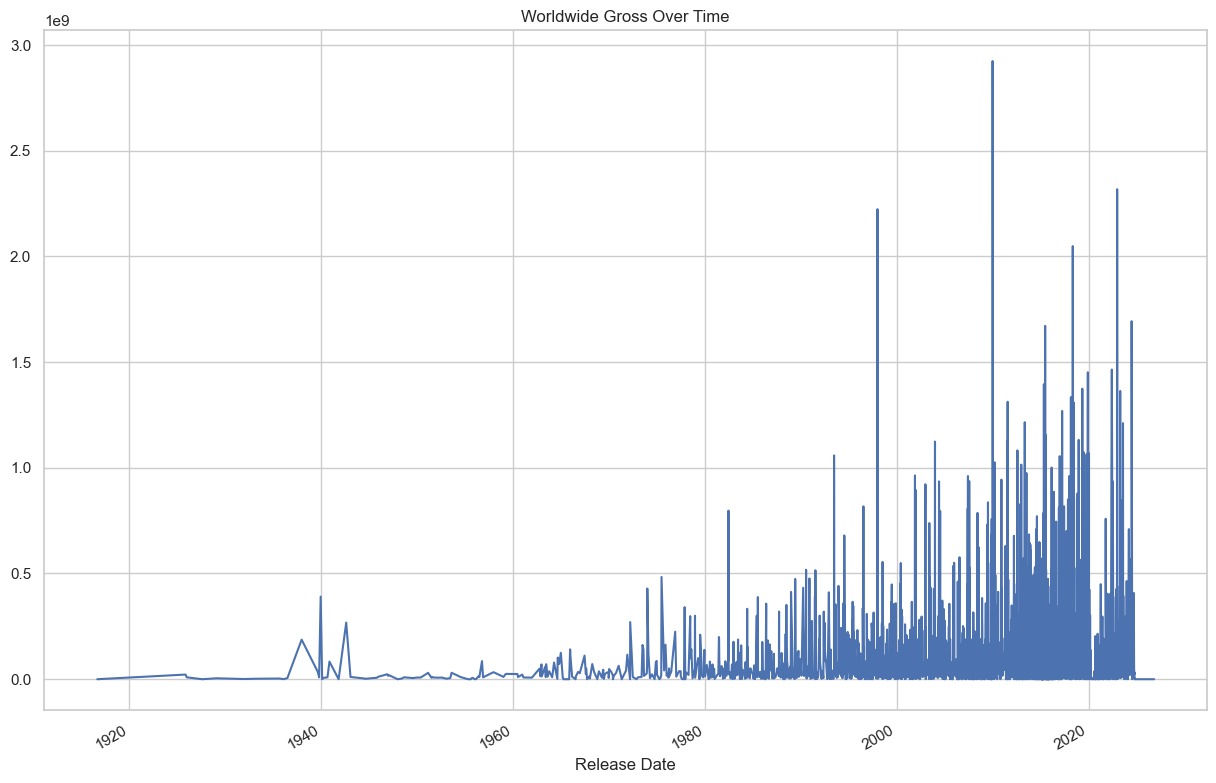

In [215]:
# Distribution of world wide gross through year
raw_data.groupby('Release Date')['Worldwide Gross'].mean().plot(title='Worldwide Gross Over Time', figsize=(15, 10))

Phew, there is no missing value

+ Descriptive Statistic

In [216]:
# Descriptive statistics of the 'Worldwide Gross'
stats = descriptive_stats(raw_data['Worldwide Gross'])

# Range
data_range = [stats['min'], stats['max']]

print("Mean: ", stats['mean'])
print("Median: ", stats['median'])
print("Mode: ", stats['mode'])
print("Quartiles: ", stats['quartiles'])
print("Percentiles: ", stats['percentiles'])
print("Deciles: ", stats['deciles'])
print("Range: ", data_range)



Mean:  97545727.49823737
Median:  29591157.0
Mode:  0.0
Quartiles:  [4.29443850e+06 2.95911570e+07 1.02198945e+08]
Percentiles:  [6.30970000e+04 2.59869102e+08]
Deciles:  [6.30970000e+04 1.70328100e+06 7.23547100e+06 1.59350680e+07
 2.95911570e+07 4.89772330e+07 8.00672835e+07 1.35406280e+08
 2.59869102e+08]
Range:  [np.float64(0.0), np.float64(2923706026.0)]


**Mean (Average):** The mean worldwide gross is approximately $97.5 million, suggesting that, on average, movies have generated significant revenue globally.

**Median:** The median worldwide gross is around $29.6 million. This show that half of the movies made less than this amount and the other half made more then this amount.

**&rarr; Mean is far higher than Median indicating that there are a few extremely high-grossing movies pulling the average up.**

**Mode:** The mode is $0, which likely means that some movies generated no revenue worldwide. The reason could be movies that were not released, were not successed or error in the crawled data

**Quartiles:**
+ First Quartile (Q1): About $4.3 million. This suggests that 25% of movies earned less than this amount.

+ Second Quartile (Median/Q2): $29.6 million.

+ Third Quartile (Q3): Around $102 million, indicating that 75% of movies made less than this amount, and only the top 25% grossed more.

**Percentiles:** The 1st percentile around $63,097 and the 99th percentile around $2.6 billion. This illustrates an extensive range in earnings, with the highest-grossing movies making much more than the vast majority.

**Deciles:** 
+ 10th percentile: About $63,097
+ 50th percentile (Median): $29.6 million
+ 90th percentile: $259.9 million
This shows that only a small percentage of movies reach the highest levels of worldwide gross.

**Range:** From $0 to $2.9 billion, indicating a substantial difference between the least and most successful movies in terms of revenue.

Overall, the data indicates a highly right skewed distribution with many movies earning relatively low revenue, while a small number reach extreme success, greatly affecting the mean.

# Metascore

+ Missing Ratio

In [217]:
print("Percentage of missing values: ", raw_data['Metascore'].isna().mean()*100)

Percentage of missing values:  14.747356051703878


+ Correlation among other numerical features

In [218]:
# conduct t-test between missing and non-missing groups for 'Metascore'
p_values_sorted, proportion_significant = missing_ttest(target_col='Metascore')

# Display results
print("T-test p-values between missing and non-missing groups for 'Metascore':")
print(p_values_sorted)

print(f"Proportion of significant features: {proportion_significant:.2f}")

T-test p-values between missing and non-missing groups for 'Metascore':
                  Column        pvalue
32              Rating_G  9.203470e-01
5         Meta UserScore  8.895964e-01
22                LGBTQ+  8.126169e-01
39          Rating_TV-MA  7.581949e-01
18               History  7.396881e-01
27               Romance  7.188325e-01
29                Sports  6.775153e-01
8              Animation  6.371936e-01
28                Sci-Fi  6.309997e-01
11                Comedy  5.983550e-01
12                 Crime  5.829132e-01
37          Rating_TV-14  4.802849e-01
23                 Music  4.614731e-01
30                   War  4.340041e-01
20                Horror  4.289557e-01
9                  Anime  4.131798e-01
16               Fantasy  3.216959e-01
21         Kids & Family  2.967850e-01
34             Rating_PG  2.810211e-01
33          Rating_NC-17  2.709163e-01
0   Tomatoes CriticScore  2.402726e-01
40          Rating_TV-PG  1.542788e-01
6                 Action  1.382

**Sumary**: Around 37% of features showed significant differences(p-value < 0.05) between the group with missing and non-missing Meta Score. Therefore, the data may not entirely missing at random. 

+ Distribution of values

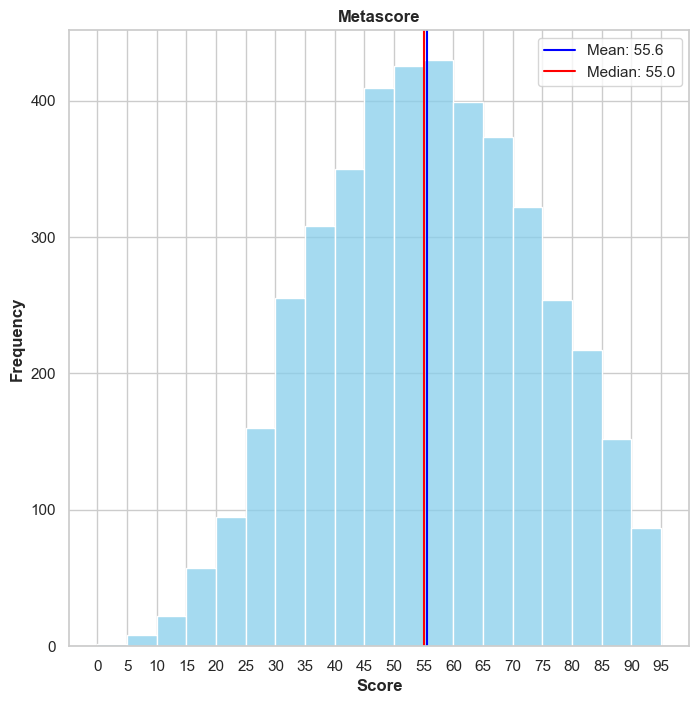

In [219]:
# Plot histogram of 'Metascore'
histogram_plot(data = raw_data['Metascore'], title = 'Metascore', xlabel = 'Score', ylabel = 'Frequency', color = 'skyblue', mean_line = True, median_line = True, bins = range(0, 100, 5))

+ Descriptive Statistic

In [220]:
# Descriptive statistics of the 'Metascore'
stats = descriptive_stats(raw_data['Metascore'])

# Range
data_range = [stats['min'], stats['max']]

print("Mean: ", stats['mean'])
print("Median: ", stats['median'])
print("Mode: ", stats['mode'])
print("Quartiles: ", stats['quartiles'])
print("Percentiles: ", stats['percentiles'])
print("Deciles: ", stats['deciles'])
print("Range: ", data_range)



Mean:  55.60509993108201
Median:  55.0
Mode:  53.0
Quartiles:  [42. 55. 69.]
Percentiles:  [31. 81.]
Deciles:  [31. 39. 45. 50. 55. 61. 66. 72. 81.]
Range:  [np.float64(1.0), np.float64(100.0)]


**Mean(Average):** The mean of the 'Metascore' is approximately 55.61. This indicates that the average Metascore across the dataset is around 56, with a slight tendency towards the higher end of the scale.

**Median:** The median is 55, which is very close to the mean. This suggests that the distribution of Metascore values is fairly symmetric, with half of the movies having scores below 55 and half above.

**Mode:** The mode is 53, which means that the most frequent Metascore value in the dataset is 53.

**Since the mode is close to Mean and Median (A little lower than them both), the data is slightly right skewed**

**Quartiles:**
+ First Quartile (Q1): 42, indicating that 25% of movies have a Metascore below 42.
+ Second Quartile (Q2, Median): 55, indicating that 50% of the movies have a score less than or equal to 55.
+ Third Quartile (Q3): 69, meaning 75% of movies have a Metascore below 69.

**Percentiles:**
+ The 1st percentile is 31, meaning 1% of movies have a Metascore below this value.
+ The 99th percentile is 81, showing that 99% of movies have a Metascore below this value. This highlights that while the bulk of movies cluster in the middle, there are some with significantly higher ratings.

**Deciles:** The deciles give a more granular view of the distribution, with scores ranging from 31 at the 10th percentile to 81 at the 90th percentile. The scores show a gradual increase across the deciles, reflecting a fairly uniform spread of Metascore values across the movies.

**Range:** The Metascore values range from 1 to 100, indicating that the scoring system spans the entire possible range, with some movies receiving extremely low scores and others near perfect ratings.

**Overall, The Metascore have a good distribution suggests that most movies fall into the middle of the scale, with fewer outliers at the end**



# Meta UserScore

+ Missing values Ratio

In [221]:
print("Percentage of missing values: ", raw_data['Meta UserScore'].isna().mean()*100)

Percentage of missing values:  18.01801801801802


+ Missing Correlation

In [222]:
# conduct t-test between missing and non-missing groups for 'Meta UserScore'
p_values_sorted, proportion_significant = missing_ttest(target_col='Meta UserScore')

# Display results
print("T-test p-values between missing and non-missing groups for 'Meta UserScore':")
print(p_values_sorted)

print(f"Proportion of significant features: {proportion_significant:.2f}")

T-test p-values between missing and non-missing groups for 'Meta UserScore':
                  Column        pvalue
27               Romance  7.651687e-01
22                LGBTQ+  7.635354e-01
37          Rating_TV-14  7.160335e-01
18               History  7.097091e-01
19               Holiday  6.945291e-01
29                Sports  6.392531e-01
9                  Anime  6.071795e-01
39          Rating_TV-MA  5.895559e-01
20                Horror  5.863439e-01
23                 Music  4.340575e-01
40          Rating_TV-PG  3.458631e-01
32              Rating_G  3.180088e-01
11                Comedy  2.459802e-01
33          Rating_NC-17  2.146101e-01
30                   War  1.873719e-01
34             Rating_PG  1.796573e-01
5              Metascore  1.711005e-01
0   Tomatoes CriticScore  1.624914e-01
28                Sci-Fi  1.279216e-01
31               Western  1.256830e-01
14                 Drama  9.407414e-02
12                 Crime  8.131438e-02
8              Animation  

**Sumary:** Around 44% of features showed significant differences(p-value < 0.05) between the group with missing and non-missing Meta UserScore. Therefore, the Meta UserScore may not entirely missing at random. 

+ Distribution of values

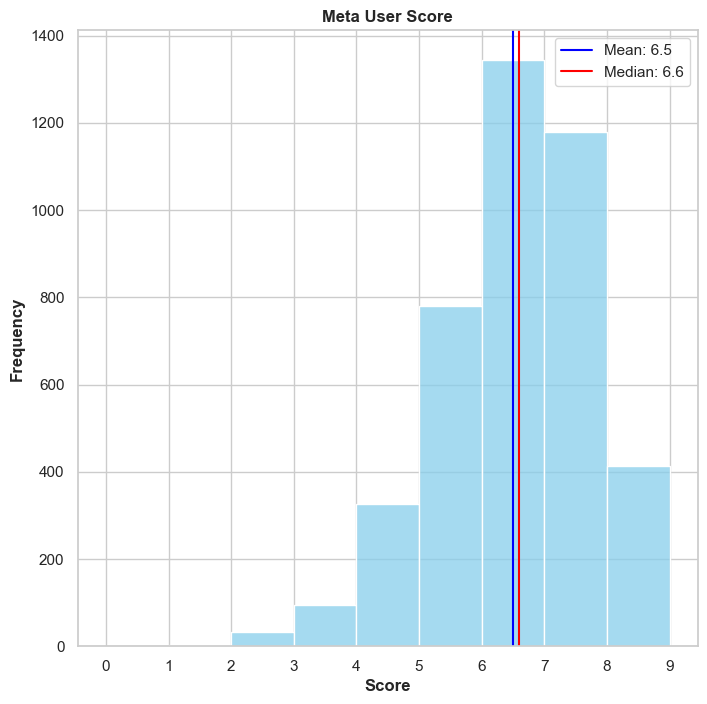

In [223]:
# Plot histogram of 'Meta UserScore'
histogram_plot(data = raw_data['Meta UserScore'], title = 'Meta User Score', xlabel = 'Score', ylabel = 'Frequency', color = 'skyblue', mean_line = True, median_line = True, bins = range(0, 10, 1))

+ Descriptive Statistic

In [224]:
# Descriptive statistics of the 'Meta UserScore'
stats = descriptive_stats(raw_data['Meta UserScore'])

# Range
data_range = [stats['min'], stats['max']]

print("Mean: ", stats['mean'])
print("Median: ", stats['median'])
print("Mode: ", stats['mode'])
print("Quartiles: ", stats['quartiles'])
print("Percentiles: ", stats['percentiles'])
print("Deciles: ", stats['deciles'])
print("Range: ", data_range)



Mean:  6.493979933110368
Median:  6.6
Mode:  6.8
Quartiles:  [5.7 6.6 7.4]
Percentiles:  [4.8 8. ]
Deciles:  [4.8 5.5 6.  6.3 6.6 6.9 7.2 7.5 8. ]
Range:  [np.float64(0.8), np.float64(10.0)]


**Mean(Average):** The mean of the 'Meta UserScore' is approximately 6.49, indicating that the average score across the dataset is just around 6.5.

**Median:**The median is 6.6, which is close to the mean. This suggests that the data is fairly symmetric, with half of the movies having scores below 6.6 and half above.

**Mode:**The mode is 6.8, meaning that the most frequent Meta UserScore value in the dataset is 6.8.

**Given the close values of mean and median, and the mode being slightly higher, this suggests a slightly left-skewed distribution (leaning towards higher scores).**

**Quartiles:**
+ First Quartile (Q1): 5.7, indicating that 25% of movies have a Meta UserScore below 5.7.
+ Second Quartile (Q2, Median): 6.6, meaning that 50% of the movies have a score less than or equal to 6.6.
+ Third Quartile (Q3): 7.4, meaning that 75% of movies have a Meta UserScore below 7.4.

**Percentiles:**
+ The 1st percentile is 4.8, meaning 1% of movies have a Meta UserScore below 4.8.
+ The 99th percentile is 8, meaning that 99% of movies have a score below this value, showing a fairly narrow distribution at the higher end of the scale.

**Deciles**:
+ The first decile is 4.8, and the ninth decile is 8, with values gradually increasing across the deciles.
+ The data is fairly evenly spread, though most movies score between 5.5 and 7.5.

**Range**: The range of Meta UserScore is from 0.8 to 10.0, meaning that while most scores cluster around the middle, there are some extreme low and high ratings.

**Overall, The Meta UserScore have a fairly balanced distribution with a little skew to the left, showing that the majority of movies have mid-range scores, with some outliers at both ends.**


### Categorical column exploration

For columns with non-numeric data types, you calculate:
- Percentage of missing values (From this and further calculation to propose a suitable approach to fill missing values of that column)
- Count no of unique values and no of element of each value (There is a column cast is quite difficult to explore, try to find a way)
- Give **visualization** to help get deeper understanding of data, from that graph/chart or any collected information give some comments on the values' distribution of that column

<h4>Platform Released Column<h4>

<h4>Cast Column<h4>

Additional function to analyze categorical columns

In [225]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set theme
sns.set_theme(style="whitegrid")

data = pd.read_csv('./Data/full_data.csv')

def general_column_analysis(df, column_name, split_values=True, delimiter=', '):
    # Percentage of missing values
    missing_percentage = df[column_name].isnull().mean() * 100
    
    if split_values:
        # Handle NaN values
        all_values = df[column_name].fillna('')
        
        # Split and count
        all_values = all_values.str.split(delimiter).explode()
        # Remove empty strings
        all_values = all_values[all_values != '']
        
        unique_values = all_values.value_counts()
        unique_count = unique_values.size
    else:
        # Original counting method for non-split columns
        unique_values = df[column_name].value_counts()
        unique_count = unique_values.size
    
    plt.figure(figsize=(12, 6))
    plot_data = unique_values.head(10)
    
    # Create horizontal bar plot
    plt.barh(y=range(len(plot_data)), width=plot_data.values, 
            color=sns.color_palette("viridis", 10))
    plt.yticks(range(len(plot_data)), plot_data.index)
    
    # Layout
    plt.title(f"Top 10 Most Common Values in '{column_name}'")
    plt.xlabel("Frequency")
    plt.ylabel(column_name)
    plt.tight_layout()
    plt.show()
    
    # top 10 genres and their counts
    print("\nTop 10 most common values:")
    print(unique_values.head(10).to_frame('Count'))

    return {
        "missing_percentage": f"{missing_percentage.round(3)}%",
        "unique_count": unique_count,
        "unique_values": unique_values
    }


<h4>Director Column<h4>

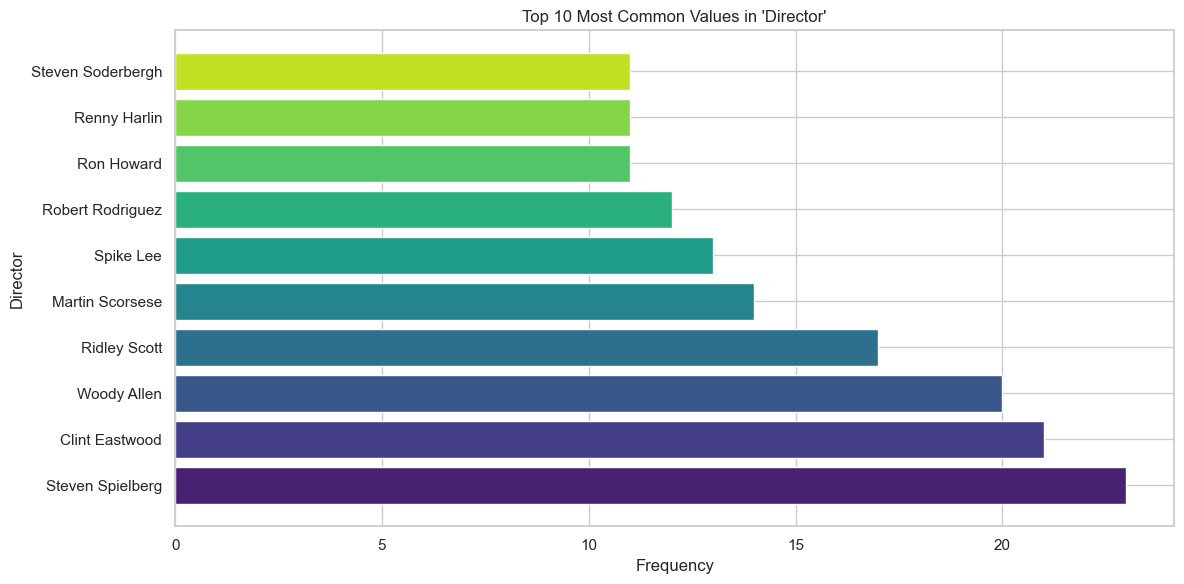


Top 10 most common values:
                   Count
Director                
Steven Spielberg      23
Clint Eastwood        21
Woody Allen           20
Ridley Scott          17
Martin Scorsese       14
Spike Lee             13
Robert Rodriguez      12
Ron Howard            11
Renny Harlin          11
Steven Soderbergh     11


{'missing_percentage': '0.685%',
 'unique_count': 3013,
 'unique_values': Director
 Steven Spielberg    23
 Clint Eastwood      21
 Woody Allen         20
 Ridley Scott        17
 Martin Scorsese     14
                     ..
 T. Hee               1
 Chinami Namba        1
 Howard Hawks         1
 Orson Welles         1
 Madoka Raine         1
 Name: count, Length: 3013, dtype: int64}

In [226]:
director_analysis = general_column_analysis(data, 'Director')
director_analysis

#### Directors analysis

Key findings
 1. Top 10 Most Frequent Directors
The dataset reveals that a small group of directors has a significantly higher representation. Here are the top ten directors by count:

- **Steven Spielberg**: 23 entries
- **Clint Eastwood**: 21 entries
- **Woody Allen**: 20 entries
- **Ridley Scott**: 17 entries
- **Martin Scorsese**: 14 entries
- **Spike Lee**: 13 entries
- **Robert Rodriguez**: 12 entries
- **Ron Howard**: 11 entries
- **Renny Harlin**: 11 entries
- **Steven Soderbergh**: 11 entries

    These directors represent a significant portion of the dataset, suggesting either their prolific careers or a dataset emphasis on well-known or frequently analyzed directors.

 2. Data Diversity
- **Unique Count**: There are **3,013 unique directors** in the dataset, reflecting substantial diversity with many lesser-known or single-appearance directors.
- **Distribution**: While a few directors appear frequently, the majority appear only once, as seen in examples like T. Hee, Chinami Namba, Howard Hawks, Orson Welles, and Madoka Raine.

 3. Missing Data
- **Missing Percentage**: The dataset has a minimal missing percentage of **0.685%**. This low rate indicates good data quality, with nearly all director entries present.

---

 Insights and Recommendations

- **Data Skewness**: The distribution shows that while many unique directors are represented, a few prominent figures dominate the dataset. This skewness could influence analyses of director influence or trends, as findings may skew toward more popular directors.
- **Analysis of Underrepresented Directors**: Given the diversity of directors, further analysis could focus on examining trends among those with only one entry. This might uncover patterns in niche genres, regional cinema, or emerging directors.
- **Considerations for Comprehensive Analysis**: If the dataset is to be used for generalizing director trends, it might be beneficial to account for the dominance of high-frequency directors, perhaps by weighting entries or segmenting by frequency categories.

---

Conclusion

The dataset offers a valuable resource for analyzing directors, with strong representation from both high-profile directors and lesser-known names. The minimal missing data ensures reliability, and the diversity in director representation opens possibilities for both mainstream and niche analyses. Further examination may benefit from separating high-frequency and single-entry directors to gain insights across the spectrum.


<h4>Genre Column<h4>

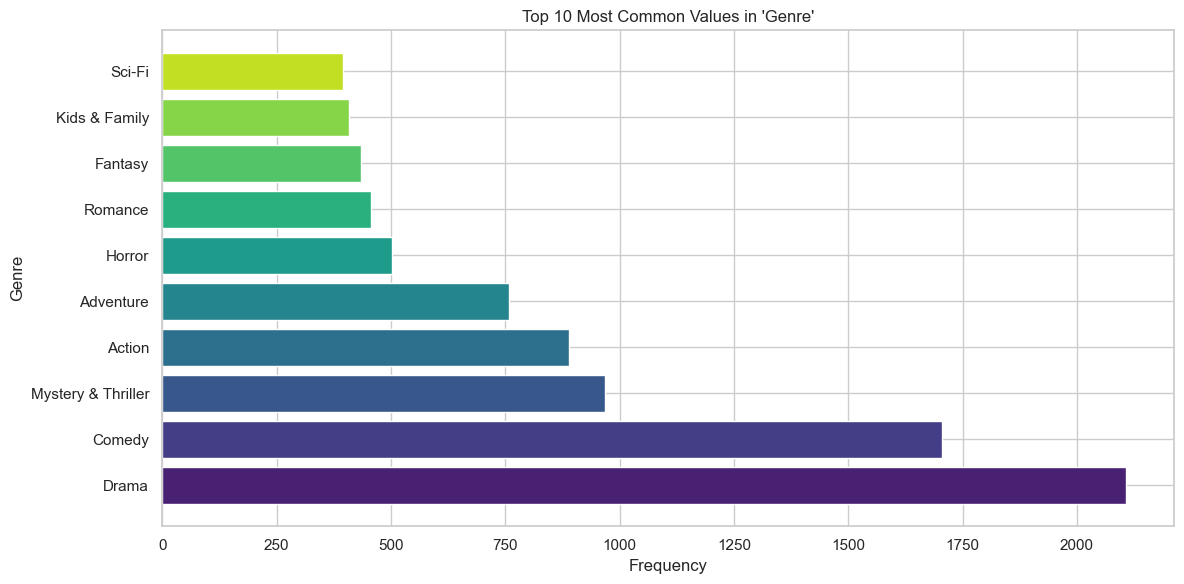


Top 10 most common values:
                    Count
Genre                    
Drama                2107
Comedy               1704
Mystery & Thriller    968
Action                890
Adventure             759
Horror                502
Romance               457
Fantasy               434
Kids & Family         408
Sci-Fi                395


{'missing_percentage': '0.901%',
 'unique_count': 26,
 'unique_values': Genre
 Drama                   2107
 Comedy                  1704
 Mystery & Thriller       968
 Action                   890
 Adventure                759
 Horror                   502
 Romance                  457
 Fantasy                  434
 Kids & Family            408
 Sci-Fi                   395
 Animation                276
 Crime                    258
 Biography                198
 History                  194
 Documentary              162
 Musical                  122
 War                      100
 LGBTQ+                    83
 Western                   77
 Holiday                   76
 Music                     38
 Anime                      8
 Foreign                    1
 Sports                     1
 Faith & Spirituality       1
 Other                      1
 Name: count, dtype: int64}

In [227]:
genre_analysis = general_column_analysis(data, 'Genre')
genre_analysis   

#### Genre Analysis
 
 Key Findings
1. Top 10 Most Frequent Genres
The dataset shows a strong concentration in a few popular genres. Here are the top ten genres by frequency:

- **Drama**: 2,107 entries
- **Comedy**: 1,704 entries
- **Mystery & Thriller**: 968 entries
- **Action**: 890 entries
- **Adventure**: 759 entries
- **Horror**: 502 entries
- **Romance**: 457 entries
- **Fantasy**: 434 entries
- **Kids & Family**: 408 entries
- **Sci-Fi**: 395 entries

    These top genres make up a significant portion of the dataset, highlighting an emphasis on mainstream genres that appeal broadly to audiences.

 2. Data Diversity
- **Unique Count**: The dataset includes **26 unique genres**, suggesting a moderate level of diversity.
- **Distribution**: While certain genres are highly prevalent, others, such as *Foreign*, *Sports*, and *Faith & Spirituality*, have minimal representation (1 entry each). This distribution indicates that niche genres are underrepresented compared to popular categories like Drama and Comedy.

 3. Missing Data
- **Missing Percentage**: The dataset has a low missing percentage of **0.901%**, indicating that the genre data is largely complete and reliable.

---

 Insights and Recommendations

- **Data Skewness**: The dataset is skewed towards mainstream genres like Drama and Comedy, which could influence analyses on genre popularity or trends, favoring these popular genres over niche ones.
- **Analysis of Underrepresented Genres**: Niche genres with few entries, such as *Foreign* and *Sports*, might benefit from separate analysis. Examining these genres could uncover unique trends and appeal factors within less common categories.
- **Considerations for Generalization**: If the dataset is used for broad genre analysis, it's essential to account for the imbalance by potentially weighting genres or segmenting analyses to prevent dominant genres from overshadowing niche insights.

---

Conclusion

The dataset provides a valuable resource for genre analysis, with solid representation of mainstream genres and a lower presence of niche categories. The low missing data ensures data reliability, and the range of genres offers potential for both mainstream and niche analyses. For a comprehensive view, further segmentation by genre frequency could yield deeper insights into both widely enjoyed and specialized genres.


<h4>Rating Column<h4>

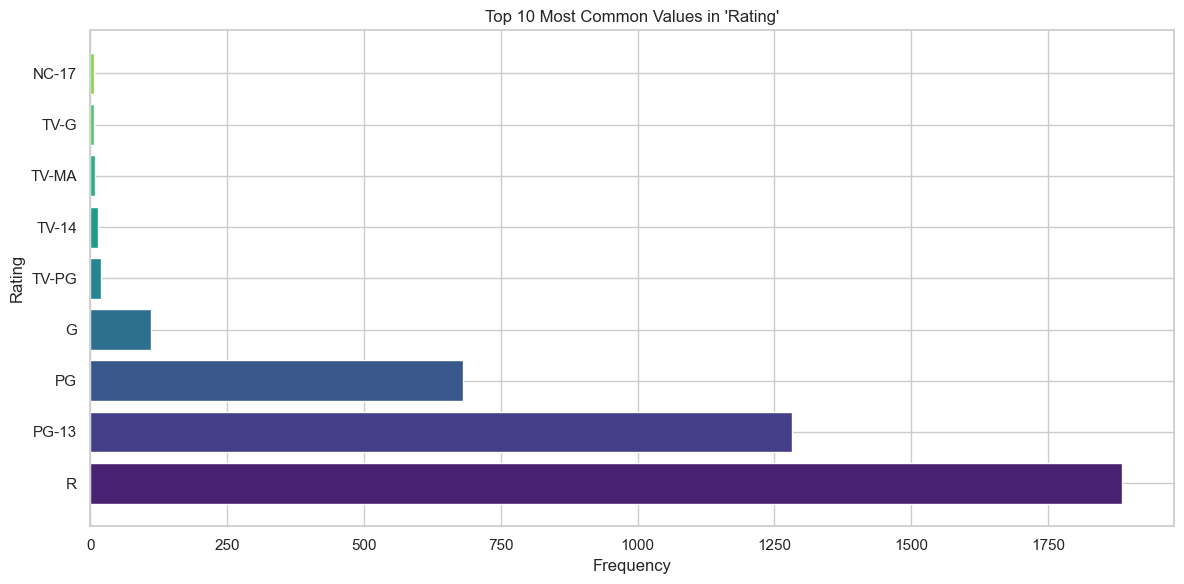


Top 10 most common values:
        Count
Rating       
R        1886
PG-13    1282
PG        680
G         111
TV-PG      19
TV-14      14
TV-MA       9
TV-G        7
NC-17       7


{'missing_percentage': '21.367%',
 'unique_count': 9,
 'unique_values': Rating
 R        1886
 PG-13    1282
 PG        680
 G         111
 TV-PG      19
 TV-14      14
 TV-MA       9
 TV-G        7
 NC-17       7
 Name: count, dtype: int64}

In [228]:

rating_analysis = general_column_analysis(data, 'Rating')
rating_analysis

#### Rating Analysis

Key Findings

1. Top 10 Most Frequent Ratings
The dataset shows a strong concentration of content rated for mature audiences. Here are the most frequent ratings by count:

- **R**: 1,886 entries
- **PG-13**: 1,282 entries
- **PG**: 680 entries
- **G**: 111 entries
- **TV-PG**: 19 entries
- **TV-14**: 14 entries
- **TV-MA**: 9 entries
- **TV-G**: 7 entries
- **NC-17**: 7 entries

    The predominance of *R* and *PG-13* ratings suggests the dataset leans towards content designed for older audiences.

2. Data Diversity
- **Unique Count**: There are **9 unique ratings** within the dataset, which covers a range of audience suitability from *G* to *NC-17*.
- **Distribution**: The bulk of entries are rated *R* and *PG-13*, while *TV* ratings (*TV-PG*, *TV-14*, *TV-MA*, *TV-G*) and *NC-17* are less represented. This distribution suggests an emphasis on theatrical releases or mature-themed content over family or TV-oriented programming.

3. Missing Data
- **Missing Percentage**: The dataset has a relatively high missing percentage of **21.367%** for ratings. This indicates that over a fifth of the entries lack rating information, potentially limiting the reliability of analyses focused on content suitability or audience targeting.

---

Insights and Recommendations

- **Data Skewness**: With *R* and *PG-13* accounting for the majority of entries, the dataset may not reflect a balanced view of family-friendly or universally suitable content.
- **Analysis of TV and Restricted Ratings**: The dataset includes a small portion of *TV* ratings (e.g., *TV-PG*, *TV-14*, *TV-MA*), suggesting limited representation of TV-exclusive content. If these ratings are of interest, supplementing the dataset with additional entries could provide a fuller picture of TV programming trends.
- **Addressing Missing Ratings**: The high missing percentage may impact analyses on content rating trends. To enhance accuracy, it is recommended to either impute missing ratings where possible or treat missing data separately to avoid skewed insights.

---

Conclusion

The dataset provides insights primarily into mature-rated and theatrically released content, with limited representation of family-friendly or TV-specific programming. The high missing data percentage suggests caution when interpreting rating distributions, as the absence of information may impact certain analyses. To create a more balanced dataset, additional entries in family and TV categories could be considered, alongside methods to address the missing ratings.


<h4>Studio Column<h4>

In [229]:
# TODO

<h1 id = "preprocessing"> 4. Preprocessing data </h1>

<h1 id = "questions"> 5. Questions </h1>

<h2 id = question-1>5.1. Question 1</h2> 

<h2 id = question-2>5.2. Question 2</h2> 

<h2 id = question-3>5.3. Question 3</h2> 

<h2 id = question-4>5.4. Question 4</h2> 

<h2 id = question-5>5.5. Question 5</h2> 

<h1 id = "modelling">6. Modelling</h1>

<h2 id = "modelling_preparation">6.1. Data preparation</h2> 

<h2 id = "models">6.2. Models</h2> 

<h2 id = "models">6.2. Models</h2> 

<h3 id = "model1">6.2.1 Model 1</h3> 

<h2 id = >

<h2 id = "evaluation">6.3. Evaluation</h2> 

<h1 id = "reflection">7. Reflection</h1> 

<h2 id = "difficulties">7.1. Difficulties during the project</h2> 

<h2 id = "useful">7.2. Useful things learned</h2> 

<h2 id = "plans">7.3. Plans to improve if have more time</h2> 

<h1 id = "references">8. References</h1> 